In [39]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import one_hot
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report,accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
train_data= pd.read_csv('../input/jigsaw-multilingual-toxic-comment-detection/jigsaw-toxic-comment-train.csv')
validation_data = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-detection/validation.csv')
test_data = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-detection/test.csv')

In [4]:
train_data.shape

(223549, 8)

In [5]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
validation_data.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [7]:
test_data.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [8]:
train_data.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [9]:
train_data.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [10]:
train_data["toxic"].value_counts()

0    202165
1     21384
Name: toxic, dtype: int64

In [11]:
train_data= train_data.loc[:15000,:]

In [12]:
train_data.shape

(15001, 3)

In [13]:
train_data["toxic"].value_counts()

0    13562
1     1439
Name: toxic, dtype: int64

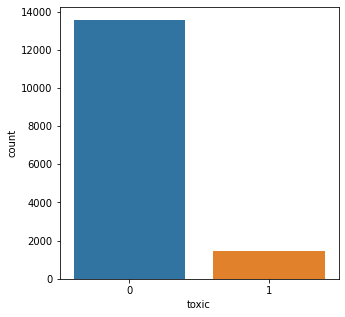

In [14]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x=train_data['toxic'],data=train_data)
plt.show()

In [15]:
test_mask=np.array(Image.open("../input/batman-logo/il_1140xN.1287758547_2nwc.png"))

In [16]:
wordcloud_text=" ".join(train_data["comment_text"].tolist())

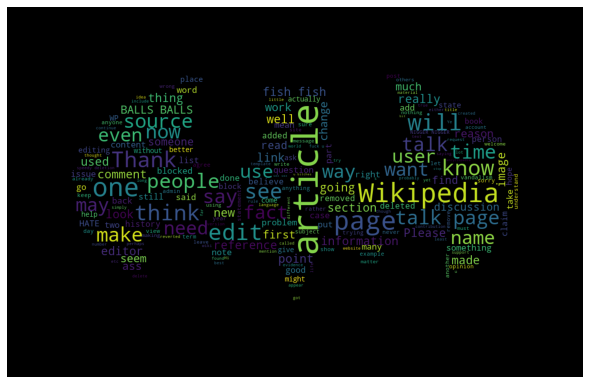

In [17]:
wordcloud=WordCloud(width=1920,height=1080,mask=test_mask,background_color ="black").generate(wordcloud_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [18]:
train_data['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

In [19]:
train_data.sample(5)

,id,comment_text,toxic
14367,25f469a447931043,"""\n\nParenthesis """"(, )"""" don't work in links\...",0
5169,0dbd4b76333ae9df,Consensus isn't truth. People can vote that gh...,0
1497,04063512ff567984,It is not a good idea to try to re-start this ...,0
13363,234bdb5e39be408a,Yogesh and his pov \nUser has a utch to add th...,0
2022,057b2a97fa00c5b0,Done. Just awaiting on the final result from t...,0


In [47]:
train_data.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [20]:
data_label=train_data["toxic"].values

In [21]:
data_text=[d.split() for d in train_data["comment_text"].tolist()]

In [22]:
embedding_dim=100
w2v_model=gensim.models.Word2Vec(sentences=data_text,vector_size=embedding_dim,window=10,min_count=1)

In [23]:
len(w2v_model.wv.key_to_index)

102934

In [24]:
w2v_model.wv.most_similar("stupid")

[('hell', 0.9460811614990234),
 ('guys', 0.9351527690887451),
 ('idiot', 0.9255852699279785),
 ('fuck', 0.9238030910491943),
 ("You're", 0.923140287399292),
 ('fucking', 0.9153474569320679),
 ('whats', 0.9150511026382446),
 ('u', 0.9102335572242737),
 ('lazy', 0.9039617776870728),
 ('dont', 0.9002833366394043)]

In [25]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(data_text)

In [26]:
data_text=tokenizer.texts_to_sequences(data_text)

In [27]:
maxlen=1000
data_text=pad_sequences(data_text,maxlen=maxlen)

In [28]:
word_index=tokenizer.word_index
vocab_size=len(tokenizer.word_index)+1


In [29]:
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

In [30]:
for word, i in word_index.items():
  try:
      embedding_vector = word_vecs[word]
  except:
    embedding_vector = None
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

  
print("Embeddings done")
vocab_size = len(embedding_matrix)

Embeddings done


In [31]:
model=Sequential()
model.add(Embedding(vocab_size,output_dim=embedding_dim,weights=[embedding_matrix],input_length=maxlen,trainable=True))
model.add(LSTM(units=128))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

2022-08-29 19:24:01.020944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 19:24:01.025826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 19:24:01.026717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 19:24:01.028449: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [32]:
X_train,X_test,Y_train,Y_test=train_test_split(data_text,data_label,test_size=0.3,random_state=42)

In [33]:
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,batch_size=10)

2022-08-29 19:24:04.329964: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-29 19:24:06.541461: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1050/1050 [==============================] - 57s 51ms/step - loss: 0.2391 - accuracy: 0.9194 - val_loss: 0.1884 - val_accuracy: 0.9365
Epoch 2/10
1050/1050 [==============================] - 53s 50ms/step - loss: 0.0941 - accuracy: 0.9668 - val_loss: 0.2990 - val_accuracy: 0.8685
Epoch 3/10
1050/1050 [==============================] - 53s 50ms/step - loss: 0.0383 - accuracy: 0.9881 - val_loss: 0.2390 - val_accuracy: 0.9216
Epoch 4/10
1050/1050 [==============================] - 53s 51ms/step - loss: 0.0181 - accuracy: 0.9942 - val_loss: 0.3044 - val_accuracy: 0.9174
Epoch 5/10
1050/1050 [==============================] - 53s 50ms/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.3640 - val_accuracy: 0.9253
Epoch 6/10
1050/1050 [==============================] - 53s 50ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.3241 - val_accuracy: 0.9285
Epoch 7/10
1050/1050 [==============================] - 53s 51ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.4056 - val_accura

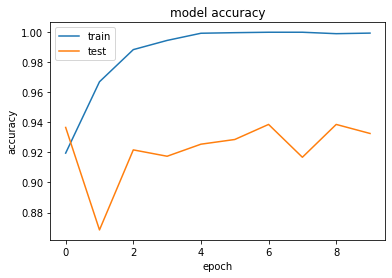

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

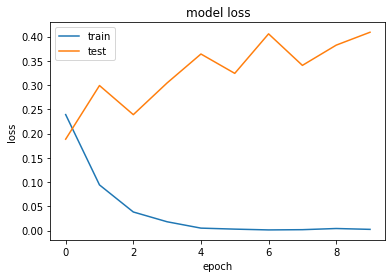

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
y_pred=(model.predict(X_test) >=0.5).astype(int)

In [40]:
accuracy_score(Y_test,y_pred)

0.9324594534547879

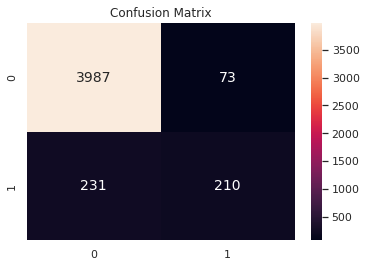

In [42]:
cm = confusion_matrix(Y_test, y_pred, labels=[0, 1])
df_cm = pd.DataFrame(cm, range(2), range(2))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={'size':14}, fmt='d').set_title('Confusion Matrix')
plt.show()

In [43]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4060
           1       0.74      0.48      0.58       441

    accuracy                           0.93      4501
   macro avg       0.84      0.73      0.77      4501
weighted avg       0.93      0.93      0.93      4501



In [48]:
x=["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since "]
x=tokenizer.texts_to_sequences(x)
x=pad_sequences(x,maxlen=maxlen)

In [49]:
prediction=(model.predict(x) >=0.5).astype(int)

In [50]:
if(prediction==1):
  print("toxic")
else:
  print("non toxic")

non toxic
